In [14]:
### %load_ext autoreload
%autoreload 2
%matplotlib inline

In [54]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray'
import seaborn as sn
import numpy as np
import cv2 as cv
import os
from pathlib import Path
import classifier
import pandas as pd
import dataset.assemble as assemble
from dataset.transform import load_and_znorm, aug_hflip, apply_all_transforms
import plot_utils as plot
from itertools import chain
from functools import reduce
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [87]:
def get_labels_from_generator(generator):
    generator.reset()
    _, y = next(generator)
    labels = y
    while generator.batch_index != 0:
        _, y = next(generator)
        labels = np.hstack((labels, y))
    return np.where(labels < 0.5, 'crystal', 'empty')
    
def get_predictions(test_generator):
    test_generator.reset()
    y_prob = model.predict_generator(test_generator, verbose=1).flatten()
    labels = np.where(y_prob < 0.5, 'crystal', 'empty')
    img, _ = test_generator.next()
    images = img
    while test_generator.batch_index != 0:
        img, _ = next(test_generator)
        images = np.hstack((images, img))
    idx = 0
    images, labels = np.array(images), np.array(labels)
    for i in range(idx, len(labels), batch_size):
        yield images[idx:idx+batch_size], labels[idx:idx+batch_size]
        idx += batch_size
        
def split_by_group(df, labels):
    from sklearn.model_selection import train_test_split
    train_df, validation_df, test_df = [pd.DataFrame()] * 3
    for label in labels:
        groups = set(df[df['label'] == label]['group'])
        train, rest = train_test_split(list(groups), test_size=0.4, random_state=42)
        validation, test = train_test_split(rest, test_size=0.5, random_state=42)
        train_df = pd.concat([train_df, df[df['group'].isin(train)]])
        validation_df = pd.concat([validation_df, df[df['group'].isin(validation)]])
        test_df = pd.concat([test_df, df[df['group'].isin(test)]])
    return dict(train=train_df, validation=validation_df, test=test_df)

def split_by_index(df):
    from sklearn.model_selection import train_test_split
    index = df.index
    train, rest = train_test_split(index, test_size=0.4, random_state=42)
    validation, test = train_test_split(rest, test_size=0.5, random_state=42)
    return dict(train=df.loc[train], validation=df.loc[validation], test=df.loc[test])

def get_group_labels():
    import json
    from collections import defaultdict
    with open('/data/staff/common/ML-crystals/classification/labels.json', 'r') as f:
        labels = json.load(f)
    group_labels = defaultdict(list)
    [group_labels[v].append(k) for k, v in labels.items()]
    return group_labels
    
def group(df, **kwargs):
    return df.assign(group=df['sample'] + '_' + df['scan'])

def filter_bad(df, **kwargs):
    group_labels = kwargs['group_labels']
    drop_indices = df[df['group'].isin(group_labels['bad'])].index
    df = df.drop(drop_indices)
    return df
    
def label(df, **kwargs):
    group_labels = kwargs['group_labels']
    s = pd.Series(name='label', index=df.index)
    empty_idx = df[df['group'].isin(group_labels['empty'])].index
    crystal_idx = df[df['group'].isin(group_labels['crystal'])].index
    bad_idx = df[df['group'].isin(group_labels['bad'])].index
    s.loc[empty_idx] = 'empty'
    s.loc[crystal_idx] = 'crystal'
    s.loc[bad_idx] = 'bad'
    return pd.concat((df, s), axis=1)

def create_dirs(dst):
    p = Path(dst)
    outer = ['train', 'validation', 'test']
    inner = ['crystal', 'empty']
    [(p / o / i).mkdir(exist_ok=False, parents=True) for i in inner for o in outer]
    
def read_images(src, shape):
    return np.array([read_image(fp, shape) for fp in Path(src).absolute().iterdir()])

def read_image(src, shape):
    mode = cv.IMREAD_COLOR if shape[-1] == 3 else cv.IMREAD_GRAYSCALE
    img = cv.imread(str(src), mode)
    shape = shape[:2]
    return cv.resize(img, shape)

def write_images(df, dst):
    from PIL import Image
    mode = 'L' if INPUT_SHAPE[-1] == 1 else 'RGB'
    n_fill = len(str(len(df)))
    for i, (_, row) in enumerate(df.iterrows()):
        Image.fromarray(row['img'], mode=mode).save(f"{DATA_DIR}/{dst}/{row['label']}/{str(i).zfill(n_fill)}.jpeg")
                                                    
def copy_images(df, dst):
    import shutil
    n_fill = len(str(len(df)))
    for i, (_, row) in enumerate(df.iterrows()):
        shutil.copy(row['filename'], f"{DATA_DIR}/{dst}/{row['label']}/{str(i).zfill(n_fill)}.jpeg")

def compose(*functions, **kwargs):
    return reduce(lambda f, g: lambda x: f(g(x, **kwargs)), functions, lambda x: x)
                    
def count_files(dir_):
    count = 0
    for root, dirs, files in os.walk(dir_):
        count += len(files)
    return count

In [5]:
DATA_DIR = Path('/data/staff/common/ML-crystals/classification/data5')
INPUT_SHAPE = (128, 128, 1)
df = assemble.get_dataset_df('/data/staff/common/ML-crystals/csv/classification.csv', has_meta=True)
df = compose(label, group, group_labels=get_group_labels())(df)
display(df.head())
# df = load_and_znorm(df, dict(input_shape=INPUT_SHAPE))

loading meta files
meta loaded


,filename,y,sample,scan,time,zoom,group,label
0,/data/visitors/biomax/20180479/20181214/raw/Sa...,39,Sample-3-09,20180479_1,2018-12-14 23:33:12.100,8,Sample-3-09_20180479_1,bad
1,/data/visitors/biomax/20180479/20181214/raw/Sa...,31,Sample-3-09,20180479_1,2018-12-14 23:33:12.430,8,Sample-3-09_20180479_1,bad
2,/data/visitors/biomax/20180479/20181214/raw/Sa...,41,Sample-3-09,20180479_1,2018-12-14 23:33:12.590,8,Sample-3-09_20180479_1,bad
3,/data/visitors/biomax/20180479/20181214/raw/Sa...,42,Sample-3-09,20180479_1,2018-12-14 23:33:12.870,8,Sample-3-09_20180479_1,bad
4,/data/visitors/biomax/20180479/20181214/raw/Sa...,42,Sample-3-09,20180479_1,2018-12-14 23:33:12.940,8,Sample-3-09_20180479_1,bad


In [7]:
empty = read_images(DATA_DIR.parent / 'empty', INPUT_SHAPE)
crystal = read_images(DATA_DIR.parent / 'crystals', INPUT_SHAPE)

In [70]:
empty_df = pd.DataFrame(data=[[a, 'empty'] for a in empty], columns=['img', 'label'])
crystal_df = pd.DataFrame(data=[[a, 'crystal'] for a in crystal], columns=['img', 'label'])
df = pd.concat([empty_df, crystal_df], ignore_index=False)

In [71]:
try:
    create_dirs(DATA_DIR)
except FileExistsError as e:
    from shutil import rmtree
    rmtree(DATA_DIR)
    DATA_DIR.mkdir()
    create_dirs(DATA_DIR)
    
d = split_by_index(df)
[write_images(df, dst) for dst, df in d.items()];

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import multi_gpu_model
from keras import optimizers
from keras.callbacks import EarlyStopping

img_width, img_height = INPUT_SHAPE[:2]
batch_size = 64
nbr_train = count_files(DATA_DIR / 'train')
nbr_validation = count_files(DATA_DIR / 'validation')
nbr_test = count_files(DATA_DIR / 'test')
epochs = 20

def cats_dogs_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=INPUT_SHAPE, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    parallel_model = multi_gpu_model(model, gpus=4)
    parallel_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=0.0001),
                  metrics=['accuracy'])
    return parallel_model


def data_generators(input_shape: tuple, batch_size: int, gen_config: dict = None, flow_config: dict = None):
    from keras.preprocessing.image import ImageDataGenerator
    if gen_config is None:
        gen_config = {}
    if flow_config is None:
        flow_config = {}
        
    gen_params = {'train':{}, 'test':{}, 'validation': {}}
    gen_params.update(gen_config)
    flow_params = {'train':{}, 'test':{}, 'validation': {}}
    flow_params.update(flow_config)
    
    width, height, channels = input_shape
    color_mode = 'grayscale' if channels == 1 else 'rgb'
    
    train_datagen = ImageDataGenerator(rescale=1. / 255, **gen_params['train'])
    validation_datagen = ImageDataGenerator(rescale=1. / 255, **gen_params['validation'])
    test_datagen = ImageDataGenerator(rescale=1. / 255, **gen_params['test'])
    
    datagens = {'train': train_datagen, 'validation': validation_datagen, 'test': test_datagen}
    
    generators = {}
    for key in gen_params.keys():
        print(f'{key}: ', end='')
        gen = datagens[key].flow_from_directory(
            f'{DATA_DIR}/{key}',
            color_mode=color_mode,
            target_size=(width, height),
            batch_size=batch_size,
            class_mode='binary', **flow_params[key])
        generators[key] = gen
        
    return generators

generators = data_generators(INPUT_SHAPE, batch_size, flow_config={'test':{'shuffle':False}})
train_generator, validation_generator, test_generator = generators['train'], generators['validation'], generators['test']

train: Found 13984 images belonging to 2 classes.
test: Found 4691 images belonging to 2 classes.
validation: Found 4653 images belonging to 2 classes.


In [ ]:
# model = classifier.build_model2(INPUT_SHAPE)
model = cats_dogs_model()
early_stopping = EarlyStopping(monitor='loss', patience=4)

history = model.fit_generator(train_generator, steps_per_epoch=nbr_train // batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nbr_validation // batch_size, callbacks=[early_stopping])

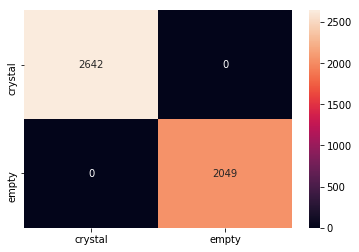

In [86]:
preds_labels = np.where(model.predict_generator(test_generator) < 0.5, 'crystal', 'empty')
gt_labels = get_labels_from_generator(test_generator)
plot.plot_confusion_matrix(gt_labels, preds_labels)

In [88]:
preds = get_predictions(test_generator)

In [93]:
images = np.array(list(chain(*[read_images(d, INPUT_SHAPE) for d in (DATA_DIR / 'test').iterdir()]))).reshape((-1, *INPUT_SHAPE))
def predictions_from_images(images):
    np.random.shuffle(images)
    preds = model.predict(images, batch_size).flatten()
    labels = np.where(preds < 0.5, 'crystal', 'empty')
    idx = 0
    for i in range(idx, len(labels), batch_size):
        yield images[idx:idx+batch_size], labels[idx:idx+batch_size]
        idx += batch_size 
preds = predictions_from_images(images)

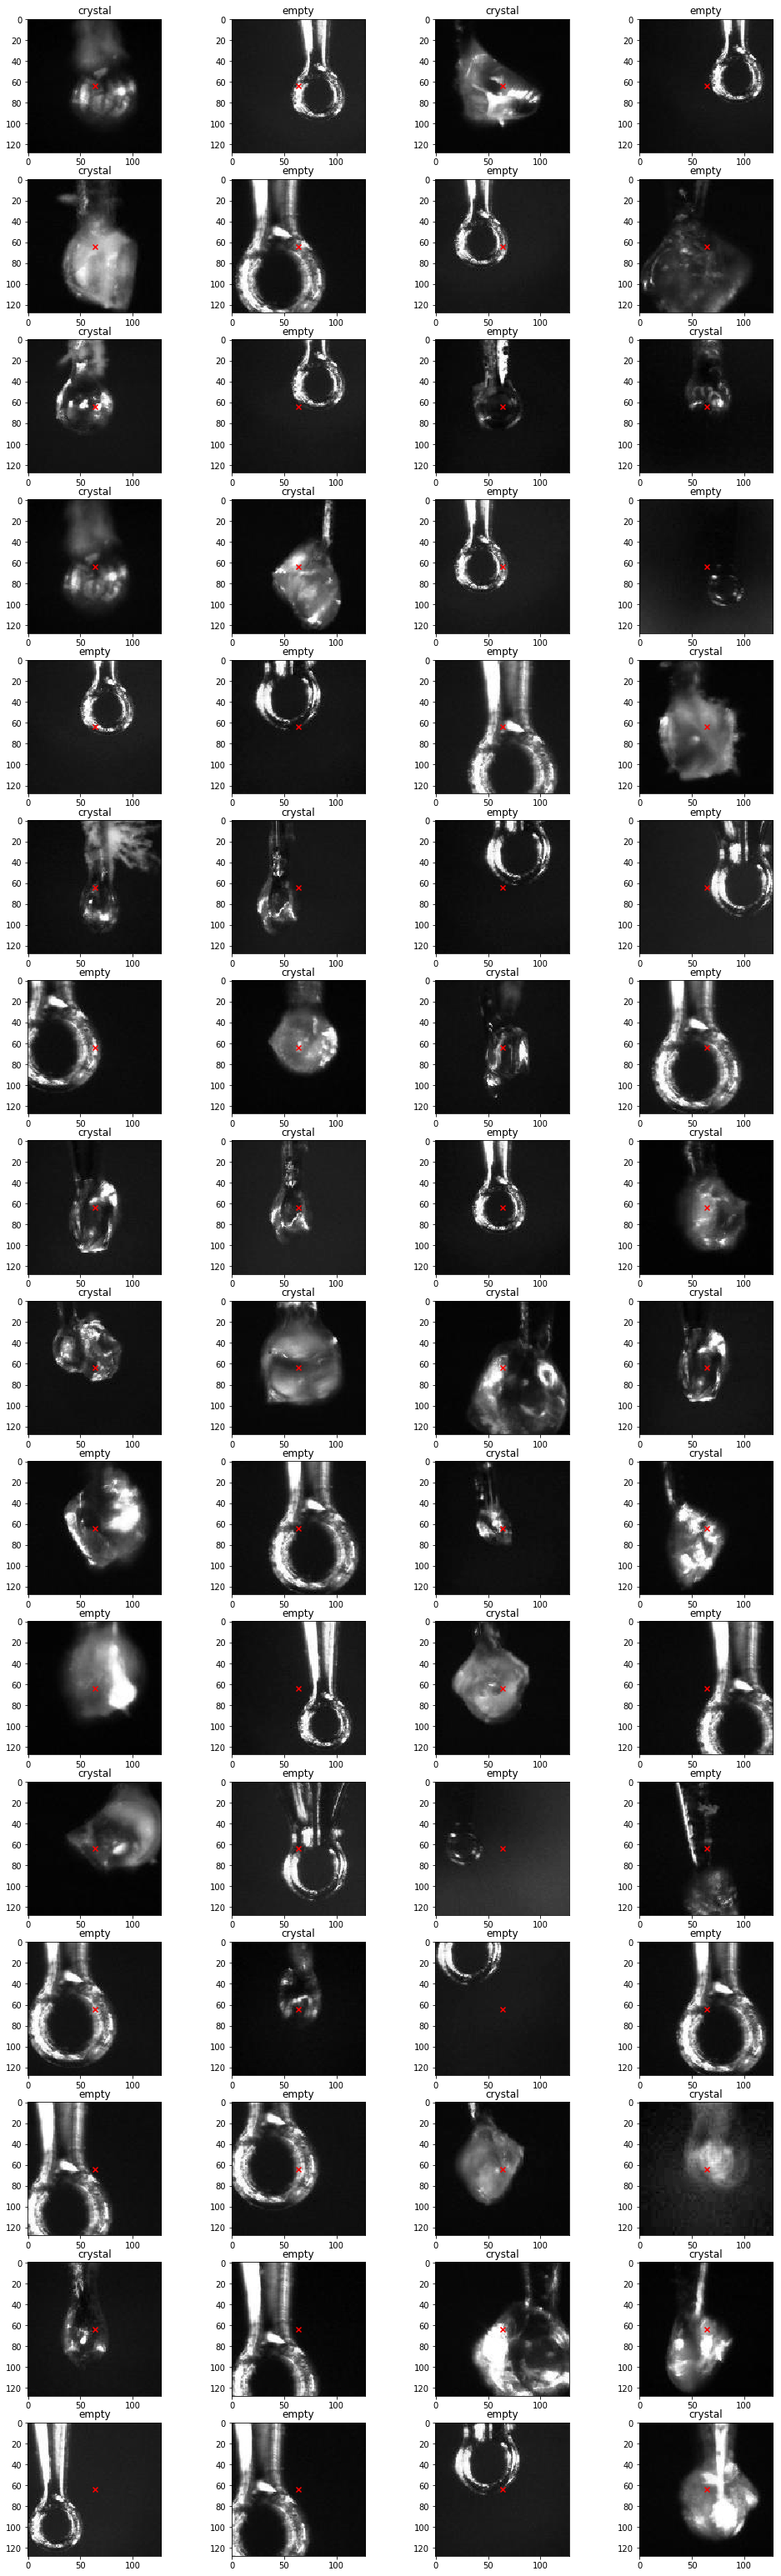

In [97]:
plot.plot_from_generator(preds)

In [8]:
from keras.models import load_model

# model.save('perfect_class.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('perfect_class.h5')